In [59]:
# Cell 1: imports and basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import zscore
import nltk
from nltk.corpus import stopwords
import re
import textwrap

nltk.download('stopwords', quiet=True)

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 5)


In [60]:
# Cell 2: load data and basic cleaning
df = pd.read_json("newsdata.json", lines=True)
df = df.head(3000)  # optional for speed

df['headline'] = df['headline'].fillna('').astype(str)
df['short_description'] = df['short_description'].fillna('').astype(str)
df['text'] = (df['headline'] + '. ' + df['short_description']).str.strip()

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).copy()
df['time_bin'] = df['date'].dt.to_period('M').dt.to_timestamp()

STOPWORDS = set(stopwords.words('english'))
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    tokens = [t for t in s.split() if t not in STOPWORDS and len(t) > 2]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

display(df[['headline','date','time_bin','clean_text']].head())


,headline,date,time_bin,clean_text
0,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-23,2022-09-01,million americans roll sleeves omicron targete...
1,"American Airlines Flyer Charged, Banned For Li...",2022-09-23,2022-09-01,american airlines flyer charged banned life pu...
2,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-23,2022-09-01,funniest tweets cats dogs week sept dog unders...
3,The Funniest Tweets From Parents This Week (Se...,2022-09-23,2022-09-01,funniest tweets parents week sept accidentally...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-22,2022-09-01,woman called cops black bird watcher loses law...


In [61]:
# Cell 3: LDA topic modeling and labeling by top terms
vectorizer = CountVectorizer(max_df=0.6, min_df=10, max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch', max_iter=10)
lda_doc_topic = lda.fit_transform(X)

df['lda_topic'] = lda_doc_topic.argmax(axis=1)

def top_words_per_topic(model, feature_names, n_top=8):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[topic_idx] = top_features
    return topics

feature_names = vectorizer.get_feature_names_out()
lda_top_words = top_words_per_topic(lda, feature_names, n_top=8)

topic_label_map = {}
for tid, words in lda_top_words.items():
    label = f"topic_{tid}:" + ",".join(words[:4])
    topic_label_map[tid] = label

df['topic_label'] = df['lda_topic'].map(topic_label_map)

for tid, words in lda_top_words.items():
    print(f"Topic {tid} -> {', '.join(words[:8])}")


Topic 0 -> ukraine, police, russia, school, said, russian, war, shooting
Topic 1 -> covid, said, gop, biden, president, vaccine, people, prince
Topic 2 -> new, star, actor, first, year, said, one, show
Topic 3 -> gop, republican, texas, trump, get, want, make, home
Topic 4 -> court, abortion, week, tweets, supreme, women, woman, funniest
Topic 5 -> trump, news, fox, host, show, former, white, late
Topic 6 -> trump, jan, capitol, man, former, election, said, says
Topic 7 -> biden, new, said, joe, climate, president, found, house


In [62]:
# Cell 4: compute topic frequencies per month and relevance metrics, build spike_df
counts = df.groupby(['time_bin', 'topic_label']).size().reset_index(name='count')
ts = counts.pivot(index='time_bin', columns='topic_label', values='count').fillna(0).sort_index()

rolling_window = 3
ts_roll = ts.rolling(window=rolling_window, min_periods=1).mean()

def safe_zscore(col):
    if np.nanstd(col) == 0:
        return np.zeros_like(col)
    return zscore(col, nan_policy='omit')

ts_z = ts_roll.apply(safe_zscore).fillna(0)

spike_threshold = 2.0
min_count_for_spike = 3
spikes = (ts_z > spike_threshold) & (ts >= min_count_for_spike)

spike_events = []
for topic in spikes.columns:
    series = spikes[topic]
    for time_bin, is_spike in series.items():
        if is_spike:
            spike_events.append({
                'time_bin': time_bin,
                'topic': topic,
                'z': float(ts_z.loc[time_bin, topic]),
                'count': int(ts.loc[time_bin, topic])
            })

spike_df = pd.DataFrame(spike_events)
if not spike_df.empty:
    spike_df = spike_df.sort_values(['time_bin', 'topic'], ascending=[True, True]).reset_index(drop=True)

display(ts.head())
display(spike_df.head())


topic_label,"topic_0:ukraine,police,russia,school","topic_1:covid,said,gop,biden","topic_2:new,star,actor,first","topic_3:gop,republican,texas,trump","topic_4:court,abortion,week,tweets","topic_5:trump,news,fox,host","topic_6:trump,jan,capitol,man","topic_7:biden,new,said,joe"
time_bin,,,,,,,,
2021-03-01,2,7,3,4,2,4,1,3
2021-04-01,16,30,21,29,14,30,15,22
2021-05-01,21,43,14,14,14,23,32,23
2021-06-01,16,24,25,19,15,15,31,31
2021-07-01,10,34,25,21,16,27,15,32


,time_bin,topic,z,count
0,2022-04-01,"topic_0:ukraine,police,russia,school",2.259932,32
1,2022-05-01,"topic_0:ukraine,police,russia,school",2.009195,32


In [63]:
# Cell 5: visualization functions and example plots
def safe_headline_snippet(df_source, t, topic, max_chars=120):
    month_docs = df_source[(df_source['time_bin'] == t) & (df_source['topic_label'] == topic)]
    if month_docs.empty:
        return None
    headline = month_docs.sort_values('date', ascending=False).iloc[0]['headline']
    return textwrap.shorten(str(headline), width=max_chars, placeholder='…')

def plot_topic_trends(topics, ts_df, ts_roll_df, ts_z_df, spike_df, df_source, rolling_window=3, exclude_spike_topics=None):
    if exclude_spike_topics is None:
        exclude_spike_topics = []
    n = len(topics)
    fig, axes = plt.subplots(n, 1, figsize=(14, 4*n), sharex=True)
    if n == 1:
        axes = [axes]
    for ax, topic in zip(axes, topics):
        if topic not in ts_df.columns:
            ax.text(0.5, 0.5, f"No data for {topic}", ha='center', va='center')
            continue

        ax.plot(ts_df.index, ts_df[topic], label='monthly count', color='C0', alpha=0.7)
        ax.plot(ts_roll_df.index, ts_roll_df[topic], label=f'{rolling_window}-month rolling avg', color='C1', linewidth=2)

        # Only draw spike markers if topic is not excluded
        if (spike_df is not None) and (topic not in exclude_spike_topics):
            topic_spikes = spike_df[spike_df['topic'] == topic] if not spike_df.empty else pd.DataFrame()
            for _, row in topic_spikes.iterrows():
                t = row['time_bin']
                ax.axvline(t, color='red', alpha=0.25)
                snippet = safe_headline_snippet(df_source, t, topic)
                if snippet:
                    if (t in ts_roll_df.index) and (not np.isnan(ts_roll_df.loc[t, topic])) and (ts_roll_df.loc[t, topic] > 0):
                        y_anchor = ts_roll_df.loc[t, topic]
                    else:
                        y_anchor = max(0.5, ts_df[topic].max() * 0.6)
                    ax.annotate(snippet,
                                xy=(t, y_anchor),
                                xytext=(5, 8),
                                textcoords='offset points',
                                fontsize=9,
                                color='darkred',
                                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.85),
                                ha='left',
                                va='bottom',
                                rotation=0)

        ax.set_title(f"Topic: {topic}")
        ax.set_ylabel("Count")
        ax.legend()
    plt.tight_layout()
    plt.show()


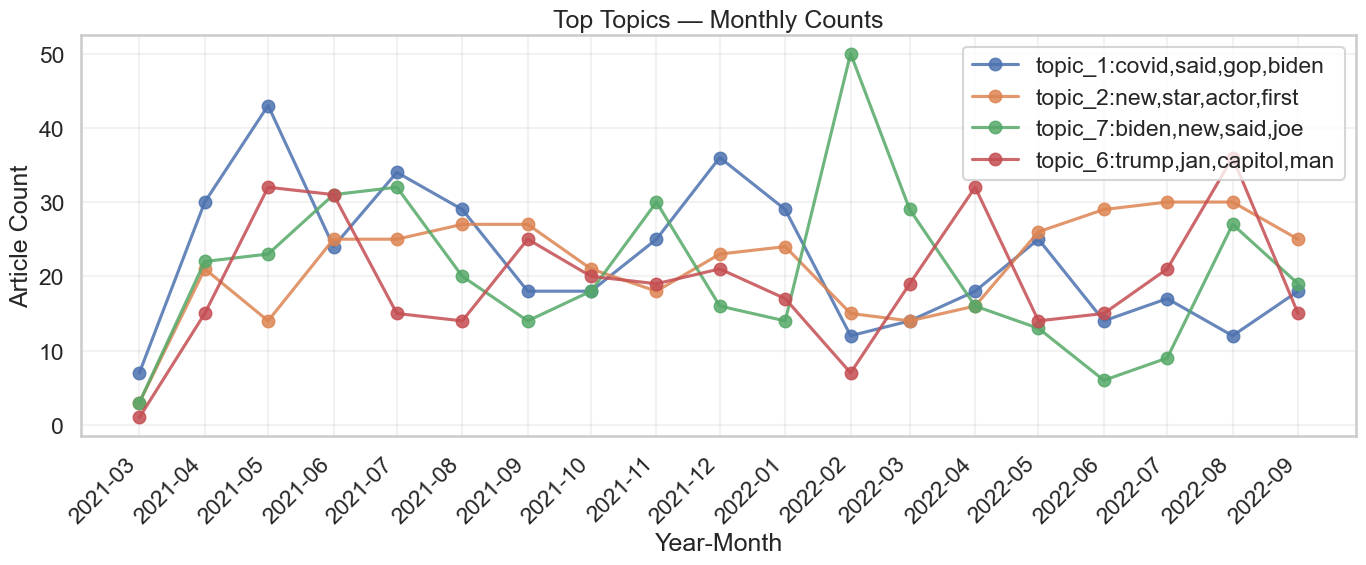

In [64]:
# Cell 6: monthly raw counts for top-5 topics (keeps Cell 5 as-is)
import matplotlib.dates as mdates

# top_topics assumed computed earlier: top_topics = list(topic_totals.head(5).index)
# If you want to exclude topic_0 from these two plots, set exclude_topics accordingly:
exclude_topics = [t for t in top_topics if t.startswith('topic_0:')]  # set [] to include all

plt.figure(figsize=(14,6))
for t in top_topics:
    if t in exclude_topics:
        continue
    plt.plot(ts.index, ts[t], marker='o', alpha=0.85, label=t)

# Format x-axis as Year-Month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Reduce tick density if many months
n_ticks = len(ts.index)
tick_step = max(1, n_ticks // 12)
ax.set_xticks(ts.index[::tick_step])

plt.xlabel("Year-Month")
plt.ylabel("Article Count")
plt.title("Top Topics — Monthly Counts")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


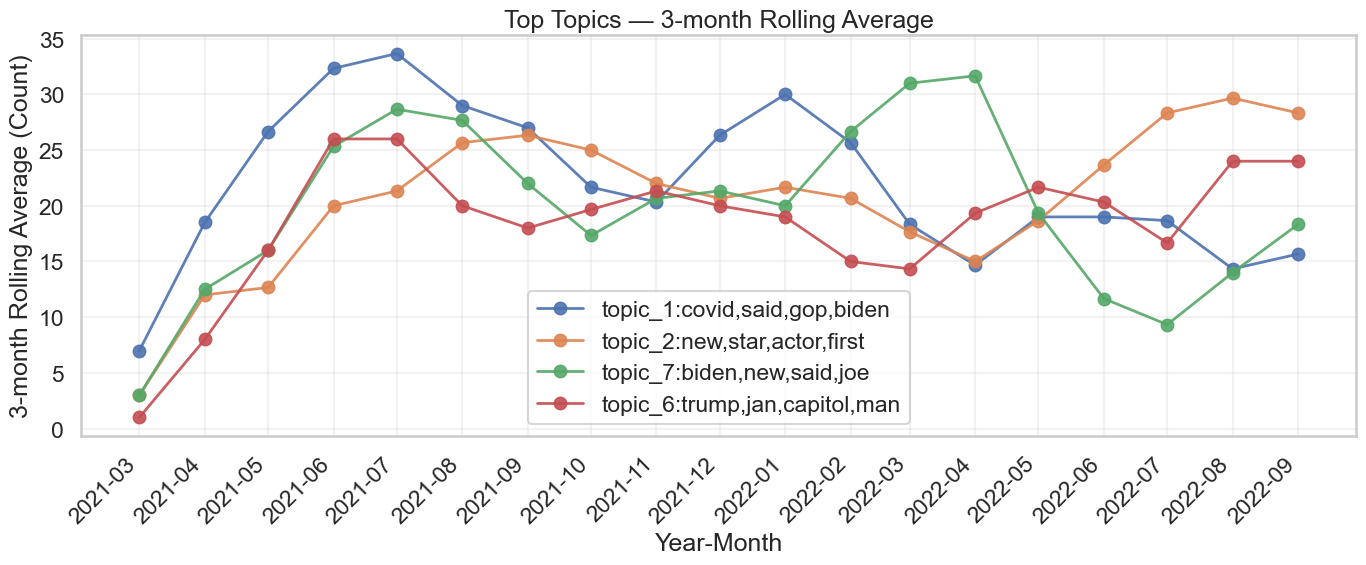

In [65]:
# Cell 7: rolling averages for the same top-5 topics (uses ts_roll computed earlier)
import matplotlib.dates as mdates

plt.figure(figsize=(14,6))
for t in top_topics:
    if t in exclude_topics:
        continue
    plt.plot(ts_roll.index, ts_roll[t], marker='o', linewidth=2, alpha=0.9, label=t)

# Format x-axis as Year-Month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Reduce tick density if many months
n_ticks = len(ts_roll.index)
tick_step = max(1, n_ticks // 12)
ax.set_xticks(ts_roll.index[::tick_step])

plt.xlabel("Year-Month")
plt.ylabel(f"{rolling_window}-month Rolling Average (Count)")
plt.title(f"Top Topics — {rolling_window}-month Rolling Average")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


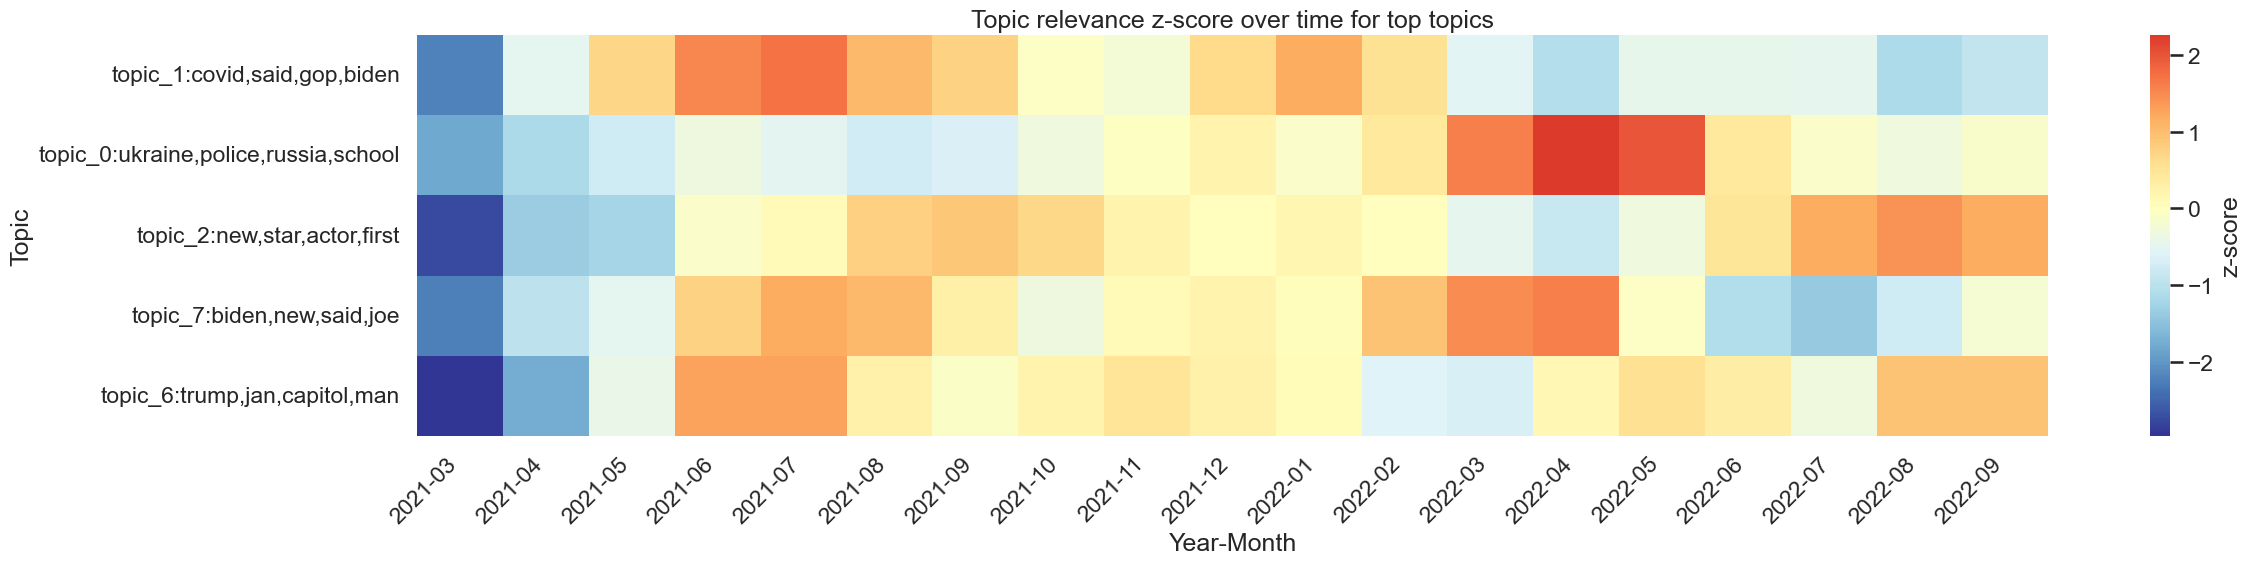

In [66]:
# Cell 8: heatmap of z-scores for top topics with Year-Month x-axis labels
plt.figure(figsize=(25,6))
heat_topics = [t for t in top_topics if t in ts_z.columns]

if heat_topics:
    ax = sns.heatmap(ts_z[heat_topics].T, cmap='RdYlBu_r', center=0, cbar_kws={'label':'z-score'})

    # Build Year-Month labels from the time index
    time_bins = ts_z.index.to_list()
    labels = [d.strftime('%Y-%m') for d in time_bins]

    # Reduce tick density if there are many months (show at most ~12 ticks)
    n_ticks = len(labels)
    tick_step = max(1, n_ticks // 12)

    # Set tick positions and labels on the heatmap x-axis
    ax.set_xticks(np.arange(0, n_ticks, tick_step) + 0.5)   # +0.5 centers ticks on heatmap cells
    ax.set_xticklabels([labels[i] for i in range(0, n_ticks, tick_step)], rotation=45, ha='right')

    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Topic')
    ax.set_title('Topic relevance z-score over time for top topics')
    plt.tight_layout()
    plt.show()
else:
    print("No top topics available for heatmap.")
